In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
!pip install vit_keras
!pip install -U tensorflow-addons
from vit_keras import vit
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=90d4ffa858c1fc88d7670e2ac537ccd809d7a369b687627c2e9d3c2be3075076
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 19.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TF version: 2.12.0
Hub version: 0.13.0
GPU is available


In [2]:
module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 16 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4 with input size (299, 299)


In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="oxford_flowers102",
    split=['train', 'validation', 'test'],
    with_info=True,
    as_supervised=True,
    batch_size=32
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteQDRKK6/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteQDRKK6/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteQDRKK6/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [4]:
IMAG_SIZE = 224 # All images will be resized to 224x224
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMAG_SIZE, IMAG_SIZE))
  return  image, label

In [5]:
train = raw_train.map(normalize_img)
validation = raw_validation.map(normalize_img)
test = raw_test.map(normalize_img)

In [6]:
do_fine_tuning = True #@param {type:"boolean"}

In [7]:
print("Building model with", MODULE_HANDLE)
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = metadata.features["label"].num_classes)

model = tf.keras.Sequential([
    vit_model,
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1072, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=metadata.features["label"].num_classes)
])
# model.build((None,)+IMAGE_SIZE+(3,))
# model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4
353253686/353253686 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [8]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [9]:
train = train.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat().shuffle(512)
validation = validation.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat()

In [10]:
steps_per_epoch = metadata.splits["train"].num_examples / BATCH_SIZE 
validation_steps = metadata.splits["validation"].num_examples / BATCH_SIZE
EPOCHS = 30
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

earlystopping = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(
    x=train,
    epochs=EPOCHS, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback, earlystopping],
    verbose=1).history

Epoch 1/30
63/63 [==============================] - 118s 431ms/step - loss: 3.9953 - accuracy: 0.1562 - val_loss: 2.9291 - val_accuracy: 0.3242
Epoch 2/30
63/63 [==============================] - 25s 391ms/step - loss: 2.1872 - accuracy: 0.4697 - val_loss: 2.5362 - val_accuracy: 0.4180
Epoch 3/30
63/63 [==============================] - 25s 389ms/step - loss: 1.4426 - accuracy: 0.6309 - val_loss: 2.2137 - val_accuracy: 0.4561
Epoch 4/30
63/63 [==============================] - 25s 389ms/step - loss: 1.1531 - accuracy: 0.7070 - val_loss: 2.3602 - val_accuracy: 0.4600
Epoch 5/30
63/63 [==============================] - 25s 392ms/step - loss: 0.8208 - accuracy: 0.7754 - val_loss: 2.3381 - val_accuracy: 0.4834
Epoch 6/30
63/63 [==============================] - 17s 267ms/step - loss: 0.6698 - accuracy: 0.8252 - val_loss: 2.8012 - val_accuracy: 0.4688
Epoch 7/30
63/63 [==============================] - 34s 535ms/step - loss: 0.4084 - accuracy: 0.8984 - val_loss: 2.0373 - val_accuracy: 0.573

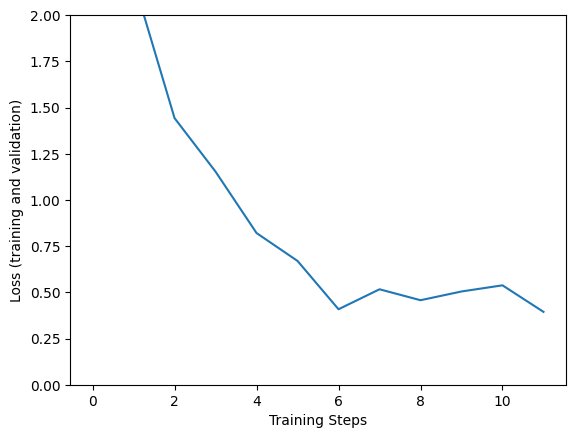

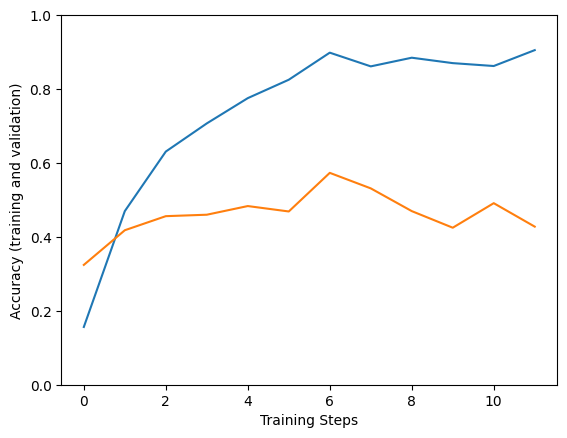

In [11]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [12]:
class_names = np.array(metadata.features['label'].names)
print(class_names)

['pink primrose' 'hard-leaved pocket orchid' 'canterbury bells'
 'sweet pea' 'english marigold' 'tiger lily' 'moon orchid'
 'bird of paradise' 'monkshood' 'globe thistle' 'snapdragon' "colt's foot"
 'king protea' 'spear thistle' 'yellow iris' 'globe-flower'
 'purple coneflower' 'peruvian lily' 'balloon flower'
 'giant white arum lily' 'fire lily' 'pincushion flower' 'fritillary'
 'red ginger' 'grape hyacinth' 'corn poppy' 'prince of wales feathers'
 'stemless gentian' 'artichoke' 'sweet william' 'carnation' 'garden phlox'
 'love in the mist' 'mexican aster' 'alpine sea holly'
 'ruby-lipped cattleya' 'cape flower' 'great masterwort' 'siam tulip'
 'lenten rose' 'barbeton daisy' 'daffodil' 'sword lily' 'poinsettia'
 'bolero deep blue' 'wallflower' 'marigold' 'buttercup' 'oxeye daisy'
 'common dandelion' 'petunia' 'wild pansy' 'primula' 'sunflower'
 'pelargonium' 'bishop of llandaff' 'gaura' 'geranium' 'orange dahlia'
 'pink-yellow dahlia?' 'cautleya spicata' 'japanese anemone'
 'black-eye

In [13]:
CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"]
output_class_names = np.array(CLASS_NAMES)

In [14]:
image_batch = []
label_batch = []
image_batch, label_batch = next(iter(test))

t = list(test.as_numpy_iterator())

for i in range(len(test)-1):
    image_batch = np.append(image_batch, t[i+1][0], axis=0)
    label_batch = np.append(label_batch, t[i+1][1], axis=0)


image_batch = image_batch
label_batch = label_batch

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

193/193 [==============================] - 25s 111ms/step
['hibiscus' 'cape flower' 'columbine' ... 'osteospermum' 'passion flower'
 'giant white arum lily']


In [15]:
predicted_output_class_names = output_class_names[predicted_ids]
print(predicted_output_class_names)

['hibiscus' 'cape flower' 'columbine' ... 'osteospermum' 'passion flower'
 'giant white arum lily']


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = predicted_ids#np.argmax(probs, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = label_batch#np.argmax(y_test, axis=1)

# Obter os nomes das classes
# class_names = list(validgen.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
# confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# # Plotar a matriz de confusão usando seaborn
# sns.set()
# sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',)
# plt.xlabel('Previsão')
# plt.ylabel('Real')
# plt.title('Matriz de Confusão')
# plt.show()


Precisão: 0.4005529354366564


In [17]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Calcular a precisão, recall e F1-score para cada classe
report = classification_report(true_classes, predicted_classes, target_names=class_names)

# Exibir o relatório de classificação
print(report)

                           precision    recall  f1-score   support

            pink primrose       0.41      0.85      0.56        20
hard-leaved pocket orchid       1.00      0.35      0.52        40
         canterbury bells       0.10      0.30      0.15        20
                sweet pea       0.11      0.25      0.16        36
         english marigold       0.75      0.13      0.23        45
               tiger lily       1.00      0.08      0.15        25
              moon orchid       0.23      0.55      0.33        20
         bird of paradise       1.00      0.23      0.38        65
                monkshood       0.42      0.62      0.50        26
            globe thistle       1.00      0.52      0.68        25
               snapdragon       0.23      0.19      0.21        67
              colt's foot       0.53      0.60      0.56        67
              king protea       0.90      0.31      0.46        29
            spear thistle       0.86      0.43      0.57     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
